In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, auc
from sklearn import model_selection

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

In [ ]:
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    source: https://towardsdatascience.com/how-to-interpret-a-binary-logistic-regressor-with-scikit-learn-6d56c5783b49
    Visualize the performance of  a Logistic Regression Binary Classifier.

    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or
        LogisticRegressionCV

    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features

    y : array-like, shape (n_samples,)
        Target vector relative to x.
        labels: list, optional
        list of text labels for the two classes, with the positive label first

    Displays
    ----------
    3 Subplots

    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]

    #FIGURE
    plt.figure(figsize=[15,4])

    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
      t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)

    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")

    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

In [ ]:
import pandas as pd
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')

In [ ]:
print('train shape  ',train.shape)

train shape   (150000, 12)


In [ ]:
train.dtypes.value_counts()

int64      8
float64    4
dtype: int64

In [ ]:
train.info()
#print(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [ ]:
train1 = train.drop(columns = ['Unnamed: 0'])
train1['SeriousDlqin2yrs'].fillna(train1['SeriousDlqin2yrs'].median(), inplace=True)
train1['RevolvingUtilizationOfUnsecuredLines'].fillna(train1['RevolvingUtilizationOfUnsecuredLines'].median(), inplace=True)
train1['age'].fillna(train1['age'].median(), inplace=True)
train1['NumberOfTime30-59DaysPastDueNotWorse'].fillna(train1['NumberOfTime30-59DaysPastDueNotWorse'].median(), inplace=True)
train1['DebtRatio'].fillna(train1['DebtRatio'].median(), inplace=True)
train1['MonthlyIncome'].fillna(train1['MonthlyIncome'].median(), inplace=True)
train1['NumberOfOpenCreditLinesAndLoans'].fillna(train1['NumberOfOpenCreditLinesAndLoans'].median(), inplace=True)
train1['NumberOfTimes90DaysLate'].fillna(train1['NumberOfTimes90DaysLate'].median(), inplace=True)
train1['NumberRealEstateLoansOrLines'].fillna(train1['NumberRealEstateLoansOrLines'].median(), inplace=True)
train1['NumberOfTime60-89DaysPastDueNotWorse'].fillna(train1['NumberOfTime60-89DaysPastDueNotWorse'].median(), inplace=True)
train1['NumberOfDependents'].fillna(train1['NumberOfDependents'].median(), inplace=True)

"""train = train.dropna()

train = train.drop(columns = ['Unnamed: 0'])"""
train1.head()
print(train1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  float64
dtype

In [ ]:
import numpy as np
features = train1.columns.values[0:30]
#print(features)
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train1[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))
#print(train[train['NumberOfDependents']== 20.0])
#print(values)"""

,9,7,0,3,10,8,5,6,1,4,2
Feature,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,RevolvingUtilizationOfUnsecuredLines,DebtRatio,age
Max duplicates,142396,141662,139974,126018,90826,56188,30062,13614,10878,4113,3837
Value,0.0,0.0,0.0,0.0,0.0,0.0,5400.0,6.0,0.0,0.0,49.0


In [ ]:
train1.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [ ]:
train_X = train1.drop(["SeriousDlqin2yrs"], axis=1)
train_y = np.log1p(train1["SeriousDlqin2yrs"].values)
print(train_y)

[0.69314718 0.         0.         ... 0.         0.         0.        ]


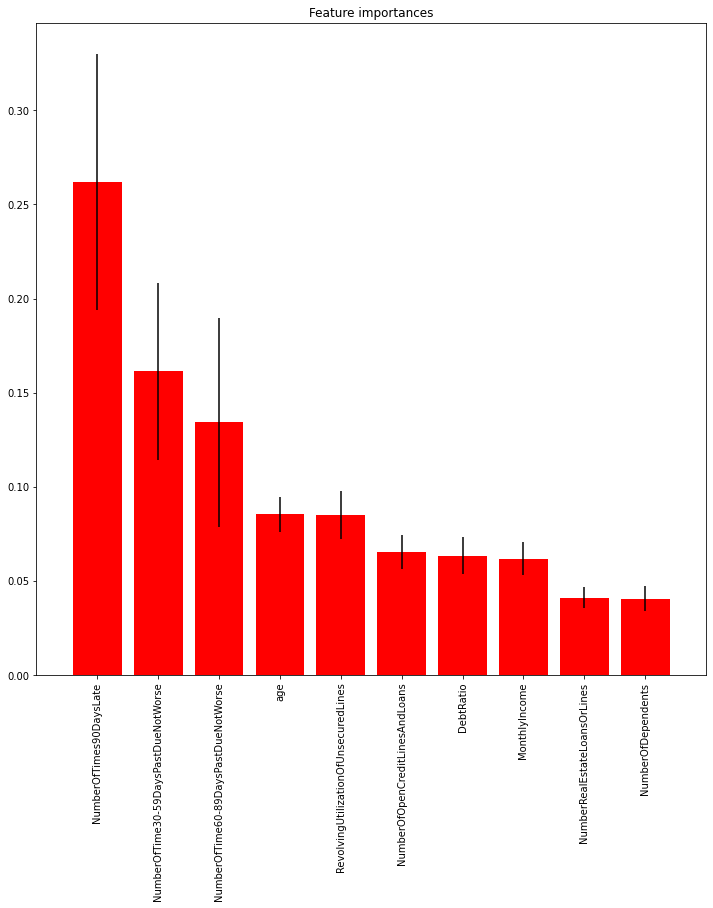

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plotando as importâncias ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
train2 = train1.drop(["age"], axis=1)
train2 = train2.drop(["RevolvingUtilizationOfUnsecuredLines"], axis=1)
train2 = train2.drop(["NumberOfOpenCreditLinesAndLoans"], axis=1)
train2 = train2.drop(["DebtRatio"], axis=1)
train2 = train2.drop(["MonthlyIncome"], axis=1)
train2 = train2.drop(["NumberRealEstateLoansOrLines"], axis=1)
train2 = train2.drop(["NumberOfDependents"], axis=1)
print(train2.shape)
print(train2.info())

(150000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column                                Non-Null Count   Dtype
---  ------                                --------------   -----
 0   SeriousDlqin2yrs                      150000 non-null  int64
 1   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64
 2   NumberOfTimes90DaysLate               150000 non-null  int64
 3   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64
dtypes: int64(4)
memory usage: 4.6 MB
None


In [ ]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [ ]:
def logistic(X,y):
    y_train=train2['SeriousDlqin2yrs'].astype('uint8')
    X_train,X_test,y_train,y_test=train_test_split(train1.drop('SeriousDlqin2yrs',axis=1),y_train,test_size=.2,random_state=2020)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)

    roc=roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('roc ',roc)
    print('lr', lr.fit(X_train,y_train))
    #print('X_train', X_train)

    print('X_Test', X_test)
    print('prob', prob)
    #print('prob', prob[:,1])"""
    print('y_train', y_train)

    return (prob[:,1],y_test)
y_train=train2['SeriousDlqin2yrs'].astype('uint8')
probs,y_test=logistic(train2.drop('SeriousDlqin2yrs',axis=1),y_train)
print('test',y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


roc  0.6850576260270774
lr LogisticRegression()
X_Test         RevolvingUtilizationOfUnsecuredLines  age  \
143572                              0.612116   34   
82758                               0.056930   30   
3479                                0.151974   77   
89329                               0.157219   59   
90675                               0.394581   43   
...                                      ...  ...   
49142                               0.000000   78   
15833                               0.000000   67   
74592                               0.046128   62   
50647                               0.338594   40   
118863                              0.424422   56   

        NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
143572                                     0  1331.000000         5400.0   
82758                                      0     0.440842         6600.0   
3479                                       0     0.190809         2001.0   
8932

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
"""print(probs)
print(y_train.head(15))
print(train)"""
#print(train.drop('SeriousDlqin2yrs',axis=1))
#print(roc_curve(y_test,probs))
"""fpr1, tpr1, thresholds1 = roc_curve(y_test,probs)
print(fpr1)
print(tpr1)
plt.plot(fpr1)
plt.plot(tpr1)"""
#plt.plot(fpr1, tpr1)

'fpr1, tpr1, thresholds1 = roc_curve(y_test,probs)\nprint(fpr1)\nprint(tpr1)\nplt.plot(fpr1)\nplt.plot(tpr1)'

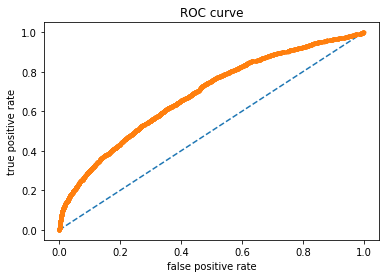

In [ ]:
plot_roc(y_test,probs)

In [ ]:
train_x, val_x, train_y, val_y=train_test_split(train2.drop('SeriousDlqin2yrs',axis=1),y_train,test_size=.2,random_state=2020)
print(y_train)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
#print('x',train_x)
#print('y',train_y)
print('u', val_y)
#print(clf)
print('pred', pred_y)
#print(val_x)"""

0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 150000, dtype: uint8
u 143572    0
82758     0
3479      0
89329     0
90675     0
         ..
49142     0
15833     0
74592     0
50647     0
118863    0
Name: SeriousDlqin2yrs, Length: 30000, dtype: uint8
pred [0 0 0 ... 0 0 0]


In [ ]:
rocrl=roc_auc_score(val_y, pred_y)
rocrl

0.5188727450300427

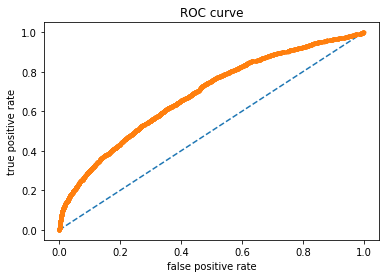

[0 0 0 ... 0 0 0]


In [ ]:
plot_roc(val_y, pred_y)
#print(val_y)
print(pred_y)

In [ ]:
%%time
model = RandomForestClassifier(n_estimators=220).fit(train_x,train_y)
predictionforest = model.predict(val_x)

CPU times: user 5.11 s, sys: 75.9 ms, total: 5.18 s
Wall time: 5.19 s


In [ ]:
%%time
rocrf=roc_auc_score(val_y, predictionforest)
print('roc ',rocrf)

roc  0.5655800819538708
CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 10.4 ms


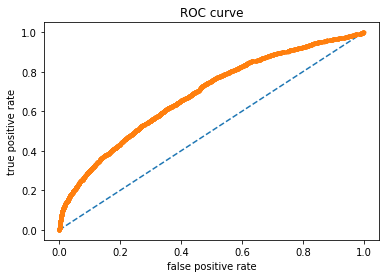

In [ ]:
plot_roc(val_y, predictionforest)

In [ ]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 220)

xgb_cfl.fit(train_x, train_y)
y_scorexgb = xgb_cfl.predict_proba(val_x)[:,1]

In [ ]:
rocxgb=roc_auc_score(val_y, y_scorexgb)
print('roc ',rocxgb)

roc  0.7833952646515544


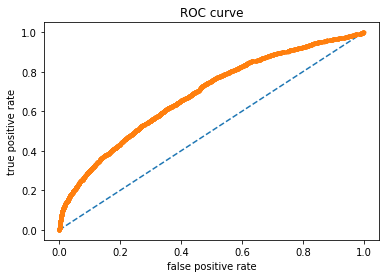

In [ ]:
plot_roc(val_y, y_scorexgb)


In [ ]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(train_x, train_y)
y_pred = xgb_cfl.predict(val_x)
y_score = xgb_cfl.predict_proba(val_x)[:,1]

In [ ]:
%%time
param_grid = {
            'n_estimators': [50, 100, 200]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(train_x, train_y)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=50; total time=   1.4s
[CV] END ....................................n_estimators=50; total time=   1.4s
[CV] END ....................................n_estimators=50; total time=   1.4s
[CV] END ....................................n_estimators=50; total time=   1.4s
[CV] END ....................................n_estimators=50; total time=   1.4s
[CV] END ...................................n_estimators=100; total time=   2.7s
[CV] END ...................................n_estimators=100; total time=   2.7s
[CV] END ...................................n_estimators=100; total time=   2.7s
[CV] END ...................................n_estimators=100; total time=   2.7s
[CV] END ...................................n_estimators=100; total time=   4.6s
[CV] END ...................................n_estimators=200; total time=   5.2s
[CV] END ...................................n_est

In [ ]:
xgb_cfl2 = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 120)

xgb_cfl2.fit(train_x, train_y)
y_score2 = xgb_cfl2.predict_proba(val_x)[:,1]

In [ ]:
rocxgb=roc_auc_score(val_y, y_score2)
print('roc ',rocxgb)

roc  0.7834088793975895


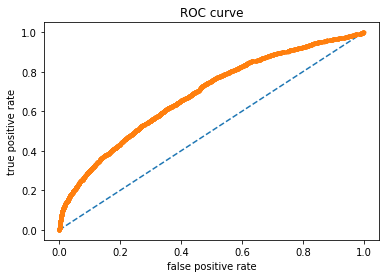

In [ ]:
plot_roc(val_y, y_score2)

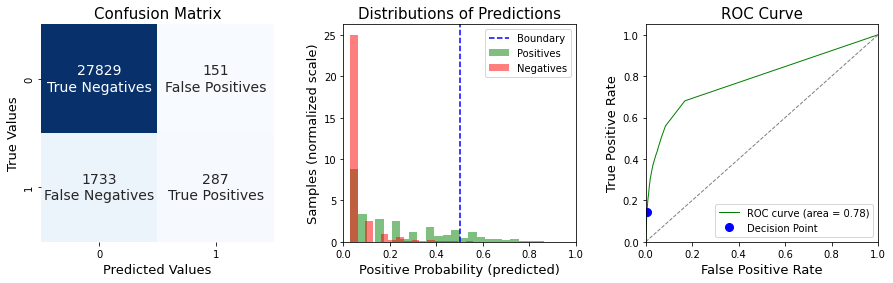

Precision: 0.66 | Recall: 0.14 | F1 Score: 0.23 | 


In [ ]:
F1 = evalBinaryClassifier(xgb_cfl2, val_x, val_y)

count    2020.000000
mean        0.236045
std         0.213886
min         0.027381
25%         0.027381
50%         0.170060
75%         0.389885
max         0.935657
Name: Probability, dtype: float64


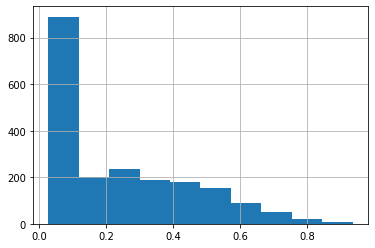

In [ ]:
## Target 1
target1 = pd.DataFrame({"Target": val_y, 'Probability': y_score2 })
print(target1.loc[target1.Target == 1, 'Probability'].describe())
target1.loc[target1.Target == 1, 'Probability'].hist()

In [ ]:
test1 =test.drop(["SeriousDlqin2yrs","Unnamed: 0"],1)
test1 =test1.drop(["age"], axis=1)
test1 =test1.drop(["RevolvingUtilizationOfUnsecuredLines"], axis=1)
test1 =test1.drop(["NumberOfOpenCreditLinesAndLoans"], axis=1)
test1 =test1.drop(["DebtRatio"], axis=1)
test1 =test1.drop(["MonthlyIncome"], axis=1)
test1 =test1.drop(["NumberRealEstateLoansOrLines"], axis=1)
test1 =test1.drop(["NumberOfDependents"], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
sampleEntry = pd.read_csv('sampleEntry.csv')

res = xgb_cfl2.predict_proba(test1)[:,1]
sampleEntry["Probability"]=res
sampleEntry.head()

,Id,Probability
0,1,0.027381
1,2,0.027381
2,3,0.027381
3,4,0.094340
4,5,0.027381


In [ ]:
sampleEntry.to_csv("submission.csv",index=False)

In [ ]:
from platform import python_version
print(python_version())

3.7.13


In [ ]:
test1.describe()
#test.describe()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
count,101503.000000,101503.000000,101503.000000
mean,0.453770,0.296691,0.270317
std,4.538487,4.515859,4.503578
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,98.000000,98.000000,98.000000
